This is the notebook to run the GRU network. It starts with a preprocessed file with p2_calib being the value to predict, and int_deliv_inv_ub and calib_time being the best values to use. It's important to note that at this point, some of the lumi measurements are taken a bit far from the calibration times. this can be seen by the difference between the lumi-section time and the calib_time values. The best data probably just consistents of the points where these are close.

All data is in its original units.

Also, I'm running this in the Python 3.7.1 Kernel

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker

In [2]:
#load the data
test = pd.read_csv('../data/test_diff.csv', index_col=0)
valid = pd.read_csv('../data/valid_diff.csv', index_col=0)
train = pd.read_csv('../data/train_diff.csv', index_col=0)
#set index to datetime periods
#test.index = pd.to_datetime(test.index).to_period('H')
#valid.index = pd.to_datetime(valid.index).to_period('H')
#train.index = pd.to_datetime(train.index).to_period('H')
#set index to datetime
test.index = pd.to_datetime(test.index)
valid.index = pd.to_datetime(valid.index)
train.index = pd.to_datetime(train.index)
train.head()

,p2,int_deliv_inv_ub
2018-05-12 09:01:31,0.000267,1.912590e+07
2018-05-12 10:01:31,0.000199,1.786448e+07
2018-05-12 11:01:31,0.000203,1.664305e+07
2018-05-12 12:01:31,0.000395,3.387666e+07
2018-05-12 13:01:31,0.000471,3.200991e+07


In [3]:
#now we will scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_scaler = StandardScaler() #we'll use the y-scaler later
y_scaler.fit(train[['p2']])
train[['p2', 'int_deliv_inv_ub']] = scaler.fit_transform(train)
train.describe()


,p2,int_deliv_inv_ub
count,2.655000e+03,2.655000e+03
mean,3.244946e-17,-1.901597e-16
std,1.000188e+00,1.000188e+00
min,-3.961264e+00,-8.967521e-01
25%,-2.381792e-01,-8.967502e-01
50%,2.085614e-01,-4.075998e-01
75%,6.130729e-01,8.383006e-01
max,2.166144e+00,2.449851e+00


In [4]:
valid[['p2', 'int_deliv_inv_ub']] = scaler.transform(valid)
valid.describe()

,p2,int_deliv_inv_ub
count,1079.000000,1079.000000
mean,0.019547,-0.047890
std,0.983953,1.041270
min,-4.176854,-0.896752
25%,-0.104290,-0.896752
50%,0.124928,-0.806050
75%,0.553043,0.889583
max,3.153585,2.358973


In [5]:
test[['p2', 'int_deliv_inv_ub']] = scaler.transform(test)
test.describe()

,p2,int_deliv_inv_ub
count,1166.000000,1166.000000
mean,0.035744,-0.625483
std,0.604301,0.685445
min,-3.867696,-0.896752
25%,-0.083353,-0.896752
50%,0.066339,-0.896752
75%,0.261708,-0.896750
max,2.375856,2.184141


In [6]:
#number of lag variables and horizon (these are just some starting choices)
T = 10 #the past N hours to study
HORIZON = 1 #predict the next N hours

#sample tensor structure
tensor_structure = {'X':(range(-T+1, 1), ['p2', 'int_deliv_inv_ub'])}

#training tensor
train_input = TimeSeriesTensor(
    dataset=train,
    target="p2",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H", #hours
    drop_incomplete=True, 
)

#validation tensor
valid_inputs = TimeSeriesTensor(valid, "p2", HORIZON, tensor_structure)
print(train_input['X'][0])
print(train_input['target'][0])
train_input['target'].shape
train_input['X'].shape

#print(valid_inputs['X'][0])
#print(valid_inputs['target'][0])

[[ 0.59420064  0.25958877]
 [ 0.44594011  0.18332401]
 [ 0.45604353  0.10947734]
 [ 0.87168012  1.15141108]
 [ 1.03762608  1.0385484 ]
 [ 0.68422353  0.92382076]
 [ 0.38075093  0.62462487]
 [ 0.89124915  0.35741122]
 [ 0.32194582  0.3213169 ]
 [-1.18816483  0.66245371]]
[-1.67139609]


(2645, 10, 2)

In [7]:
#now we bring in the keras tensorflow model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError
from tensorflow.keras.utils import plot_model

#from keras_visualizer import visualizer

from math import pow, floor
import time

In [8]:
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.00001
    drop = 0.5
    epochs_drop = 200
    lrate = initial_lrate * pow(drop, floor((1+epoch)/epochs_drop))
    return initial_lrate

def my_loss_fn(y_true, y_pred):
    return y_true - y_pred

v. 0 Latent_dim:  50 L2 Regularizer:  0.0 Optimizer: Adam Batch size: 100
Epoch 1/1000
27/27 [==============================] - 6s 130ms/step - loss: 1.1616 - val_loss: 1.0327
Epoch 2/1000
27/27 [==============================] - 1s 21ms/step - loss: 0.9883 - val_loss: 0.9102
Epoch 3/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.8695 - val_loss: 0.8347
Epoch 4/1000
27/27 [==============================] - 0s 14ms/step - loss: 0.8212 - val_loss: 0.7799
Epoch 5/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.7978 - val_loss: 0.7333
Epoch 6/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.7182 - val_loss: 0.6940
Epoch 7/1000
27/27 [==============================] - 0s 15ms/step - loss: 0.7048 - val_loss: 0.6572
Epoch 8/1000
27/27 [==============================] - 0s 13ms/step - loss: 0.6537 - val_loss: 0.6260
Epoch 9/1000
27/27 [==============================] - 0s 14ms/step - loss: 0.5992 - val_loss: 0.5973
Epoch 10/1000
27

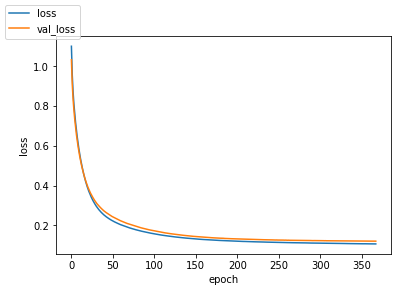

In [9]:
#best params:
#Latent_dim:  50 L2 Regularizer:  0.0
#Final Val Loss: 0.14
#optimizer Adam
#batch size 100
#initial rate 0.0001
#drop 0.5
#epochs drop 50
reg_vals = [0.0]
optimizers = ['Adam']
val_results = []
batch_size = [100]
ndims = [50]
losses = [MeanSquaredError()]
for loss in losses:
    for ndim in ndims:
        for reg_val in reg_vals:
            for optimizer in optimizers:
                for batch in batch_size:
                    for i in range(0,1):
                        print('v.',i,'Latent_dim: ',ndim,'L2 Regularizer: ', reg_val,'Optimizer:',optimizer, 'Batch size:',batch)


                        t_start = time.time()
                        LATENT_DIM = ndim
                        BATCH_SIZE = batch
                        EPOCHS = 1000

                        lrate = LearningRateScheduler(step_decay)
                        model = Sequential()
                        model.add(SimpleRNN(LATENT_DIM,return_sequences=True, input_shape=(T, 2), kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        model.add(SimpleRNN(LATENT_DIM,return_sequences=True, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        model.add(SimpleRNN(LATENT_DIM, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val), bias_regularizer=l2(reg_val)))
                        #model.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
                        model.add(Dense(HORIZON))
                        model.compile(optimizer=optimizer, loss=loss, 
                                     # metrics=['accuracy']
                                     )

                        earlystop = EarlyStopping(monitor="val_loss", min_delta=0.0, patience=5)
                        model_history = model.fit(
                        train_input["X"],
                        train_input["target"],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(valid_inputs["X"], valid_inputs["target"]),
                        callbacks=[earlystop, lrate],
                        verbose=1,
                        )
                        
                        # list all data in history
                        #print(model_history.history.keys())
                        total_time = time.time()-t_start
                        #make a model picture
                        model.summary()
                        #model_vis = visualizer(model, format='png', view=True)
                        model_vis = plot_model(model, to_file='model.png')
                        # summarize history for loss
                        fig, ax = plt.subplots()
                        ax.plot(model_history.history['loss'])
                        ax.plot(model_history.history['val_loss'])

                        ax.set_ylabel('loss')
                        ax.set_xlabel('epoch')
                        fig.legend(['loss', 'val_loss'], loc='upper left')
                        #plt.show()
                        print('\tFinal Val Loss:',model_history.history['val_loss'][-1],' in: {}s'.format(total_time))
                        if(model_history.history['val_loss'][-1] < 1.0):
                            val_results.append((ndim,reg_val,model_history.history['val_loss'][-1],optimizer,total_time,batch,fig,model_vis))
                        else:
                            plt.close()

In [11]:
#for result in val_results:
  #  print("ndim: ",result[0])
  #  print("reg_val: ",result[1])
  #  print("val_loss: ",result[2])
  #  print("optimizer: ",result[3])
df_results = pd.DataFrame(val_results, columns=['hidden_dimensions','L2_reg_val','final_val_loss','optimizer','training_time','batch_size','FIG','MODEL_VIS'])
res_grps = df_results.groupby('batch_size')
for batch in batch_size:
    print('Batch size: {}'.format(batch))
    df_batch = res_grps.get_group(batch).drop(['batch_size','hidden_dimensions','L2_reg_val'],axis=1)
    print('\tAvg final val loss: {:.2f}+-{:.2f}'.format(df_batch.final_val_loss.mean(),df_batch.final_val_loss.std()))
    print('\tAvg training time: {:.2f}+-{:.2f}'.format(df_batch.training_time.mean(),df_batch.training_time.std()))
    
for count,result in enumerate(val_results):
    result[-1].savefig('loss-curve_batch-size_{}_{}.png'.format(result[-4],count))

Batch size: 100
	Avg final val loss: 0.12+-nan
	Avg training time: 146.48+-nan


AttributeError: 'NoneType' object has no attribute 'savefig'

In [12]:
df_results

,hidden_dimensions,L2_reg_val,final_val_loss,optimizer,training_time,batch_size,FIG,MODEL_VIS
0,50,0.0,0.120912,Adam,146.479412,100,Figure(432x288),None


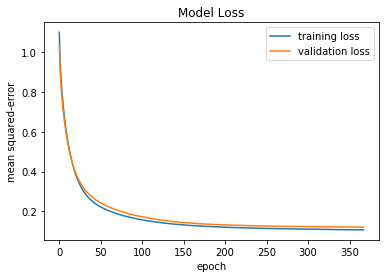

In [13]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('mean squared-error')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

In [14]:
#now we'll test
data_test_inputs = TimeSeriesTensor(test, "p2", HORIZON, tensor_structure)
#print(data_test_inputs['X'][0])
#print(data_test_inputs['target'][0])

predictions = model.predict(data_test_inputs["X"])
#print(predictions)
ev_data = create_evaluation_df(predictions, data_test_inputs, HORIZON, y_scaler)
ev_groups = ev_data.groupby('h')
#test.head()
gr1 = ev_groups.get_group('t+1')

In [15]:
gr1.describe()

,prediction,actual
count,1.156000e+03,1156.000000
mean,7.363881e-07,0.000010
std,2.647484e-04,0.000279
min,-1.364740e-03,-0.001788
25%,-8.432985e-05,-0.000045
50%,1.155701e-05,0.000024
75%,1.308276e-04,0.000114
max,8.655438e-04,0.001087


In [16]:
apes = []
for i in range(0, gr1.prediction.count()):
    if gr1.actual.iloc[i] == 0:
        continue
    ape = abs((gr1.prediction.iloc[i] - gr1.actual.iloc[i]) / gr1.actual.iloc[i])
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))

print('Evaluating GRU')
print("MAPE prediction 1 hour  ahead: {:.2%}".format(mape1))

Evaluating GRU
MAPE prediction 1 hour  ahead: 337.33%


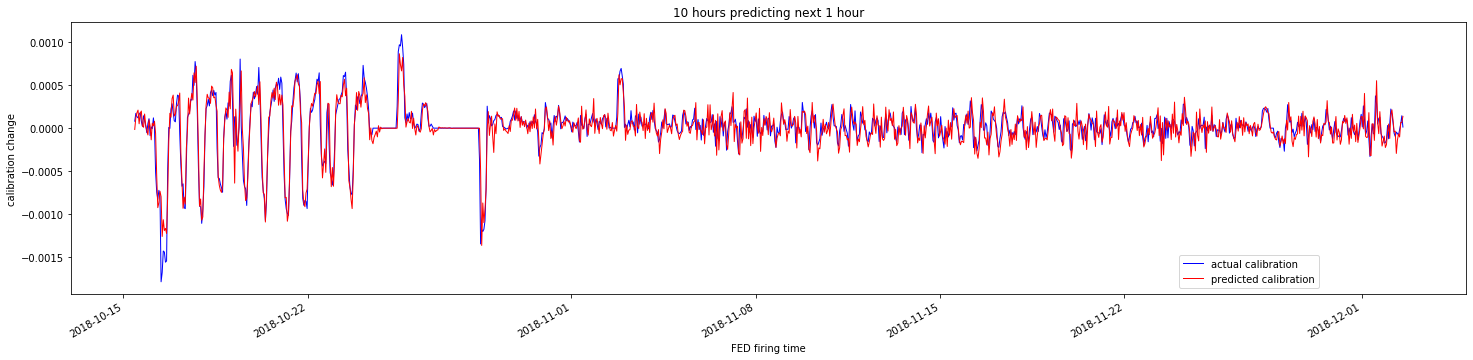

In [22]:
#lets plot our results
fig, ax = plt.subplots(figsize=(25,5))

ev_group = ev_groups.get_group('t+1')

ax.set_title('{time:.0f} hours predicting next 1 hour'.format(time=T))
ax.set_ylabel('calibration change')
ax.set_xlabel('FED firing time')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

ax.plot(ev_group.timestamp, ev_group.actual, 
         label='actual calibration', color='blue', linewidth=1, linestyle='solid')

ax.plot(ev_group.timestamp, ev_group.prediction, 
         label='predicted calibration', color='red', linewidth=1, linestyle='solid')
#legend
fig.legend(ncol=1, loc = (0.8,0.2))
fig.show()

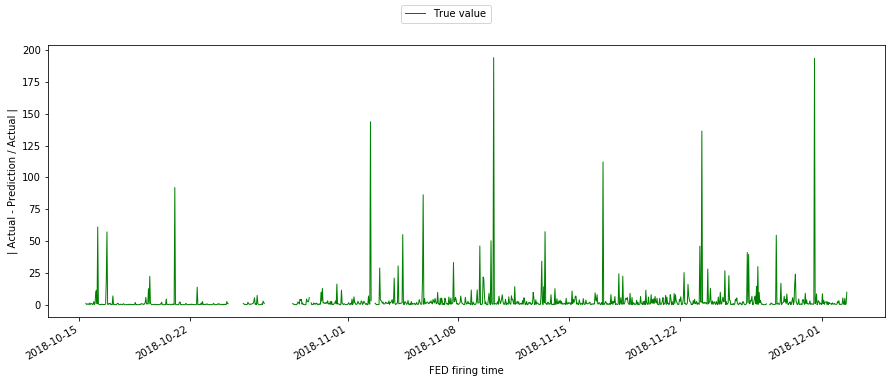

In [18]:
####MAKE DIFF PLOT########
apdiff_series = ((ev_group.actual - ev_group.prediction) / ev_group.actual).abs()
fig3, ax3 = plt.subplots(figsize=(15,5))

ax3.set_ylabel('| Actual - Prediction / Actual |')
ax3.set_xlabel('FED firing time')
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

#actual data
ax3.plot(ev_group.timestamp, apdiff_series, 
     label='True value', color='green', linewidth=1, linestyle='solid')
#legend
fig3.legend(ncol=3, loc = 'upper center')


In [19]:
#our data is transformed to feed into the model. The diff step transforms the data by removing the large scale trends. We'll run that in reverse to look at the data with the trends.
ev_data_int = ev_data.copy()
ev_data_int['prediction'] = ev_data_int['prediction'].cumsum()
ev_data_int['actual'] = ev_data_int['actual'].cumsum()
ev_data.head()

,timestamp,h,prediction,actual
0,2018-10-15 10:36:23,t+1,-0.000015,0.000081
1,2018-10-15 11:36:23,t+1,0.000122,0.000172
2,2018-10-15 12:36:23,t+1,0.000179,0.000134
3,2018-10-15 13:36:23,t+1,0.000210,0.000119
4,2018-10-15 14:36:23,t+1,0.000051,0.000161


/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


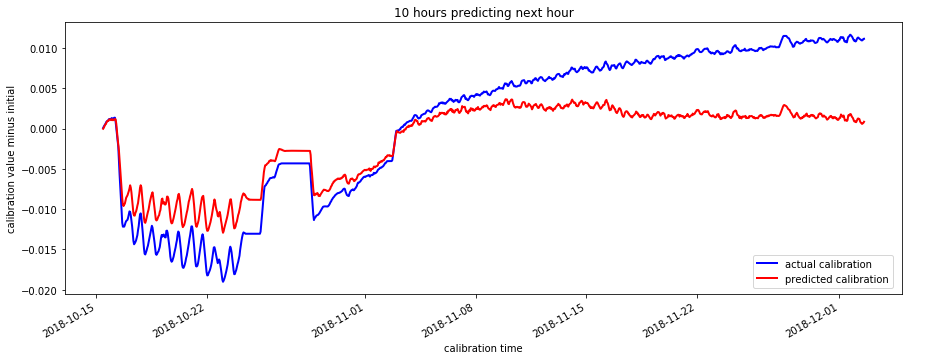

In [20]:
#lets plot our results
fig10, ax13 = plt.subplots(figsize=(15,5))

ax13.set_title('{time:.0f} hours predicting next hour'.format(time=T))
ax13.set_ylabel('calibration value minus initial')
ax13.set_xlabel('calibration time')
plt.setp(ax13.get_xticklabels(), rotation=30, horizontalalignment='right')

ax13.plot(ev_data_int.timestamp, ev_data_int.actual, 
         label='actual calibration', color='blue', linewidth=2, linestyle='solid')

ax13.plot(ev_data_int.timestamp, ev_data_int.prediction, 
         label='predicted calibration', color='red', linewidth=2, linestyle='solid')

#lumi data on alternate y axis
#ax14 = ax13.twinx()
#ax14.set_ylabel('integrated luminosity (/ub)')
#
#ax14.plot(test_lumi_avg.index, test_lumi_avg, 
#         label='lumi averaged', color='limegreen', linewidth=1, linestyle='dashed')

#legend
fig10.legend(ncol=1, loc=(0.8,0.2))
#plt.ylim([-.05, ev_data_int.actual.max()*1.1])
fig10.show()

In [21]:
apes = []
for i in range(0, gr1.prediction.count()):
    if gr1.actual.iloc[i] == 0:
        continue
    ape = abs((gr1.prediction.iloc[i] - gr1.actual.iloc[i]) / gr1.actual.iloc[i])
    apes.append(ape)
    
mape1 = (sum(apes) / len(apes))
mape1

3.3733062752779057